In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import subprocess
from pathlib import Path



"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [2]:
#data
BA_breweries = pd.read_csv('data/minimizedData/BA_breweries_small.csv')
RB_breweries = pd.read_csv('data/minimizedData/RB_breweries_small.csv')
BA_users = pd.read_csv('data/minimizedData/BA_users_small.csv')
RB_users = pd.read_csv('data/minimizedData/RB_users_small.csv')
BA_merged = pd.read_csv('data/minimizedData/BA_ratings_small_plus.csv')
RB_merged = pd.read_csv('data/minimizedData/RB_ratings_small_plus.csv')

#BA US data
BA_US_ratings = pd.read_csv('data/USData/BA_US_states_all.csv')

In [3]:
#sent and clustering
BA_US_knn_text = pd.read_csv('data/knnData/BA_US_knn_text.csv')

### Exploring Geographical Bias in Beer Ratings: Is your State swaying you Sip?

#### Introduction

Countries often claim that they have the “best” beer, in this article we are going to analyse the US and see if we can quantify a bias that people from different states have for each other's beers. Does the state you are from influence your beer preferences, especially towards beers coming from your own state? More generally, by examining the data from the Beer Advocate beer review website, we aim to uncover links between a user's geographical location, and how they rate beers. We were inspired by different regions of the world having similar food, so to try and find trends in beer data we’re going to start with a ‘regional’ analysis of states. Additionally, we will attempt to explain and find reasons for the bias in preference by looking at various factors, such comparing specifically neighbouring states, or analysing differences in beer style preferences. 

#### Data pipeline

To start, if you want to run the pipeline yourself, the given data needs to be in ‘data/baseData’. So the first thing we do is basic preprocessing, removing all the columns that we won’t need, and also importantly converting the .txt file into a .csv. We also compute some extra columns that we know are going to be useful, such as collecting location data from the breweries file and adding it to the beer file. This all goes into ‘data/minimizedData/’. We did some initial analyses with this data. Next, after we had decided to focus on the US only, we added to our pipeline to collect only US data from ‘minimizedData’, this US specific data goes into ‘data/USData/’. Finally we added another separate folder for our clustering algorithms, ‘data/knnData’, since we knew that we would need some additional features not present in ‘minimizedData’. The pipeline processes both the BeerAdvocate and RateBeer data, this was on purpose, so that we could test the 2 and see if there were any big differences, but there were not, and as we will explain just underneath we decided to focus solely on the Beer Advocate data.

#### The data we used

We had access to a large, high-quality dataset in the form different stats collected from the jus‘BeerAdvocate’ website as well as the ‘RateBeer’ website, but for our analyses, we found it largely sufficient to only use data from ‘BeerAdvocate’. Indeed we can see that the BeerAdvocate dataset has a higher percentage of US based users compared to users in the RateBeer dataset. Since we wanted to focus on a well defined geographical region, we thought it suitable to limit our data to US users as well as to the more US centered dataset; BeerAdvocate.


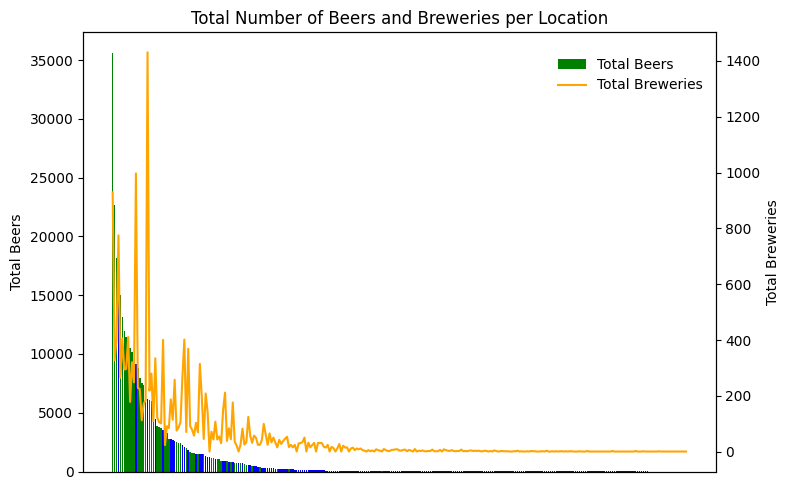

In [4]:
from src.choosingCountries.utils.beers_breweries import plot_beer_breweries_distribution

plot_beer_breweries_distribution(BA_breweries)

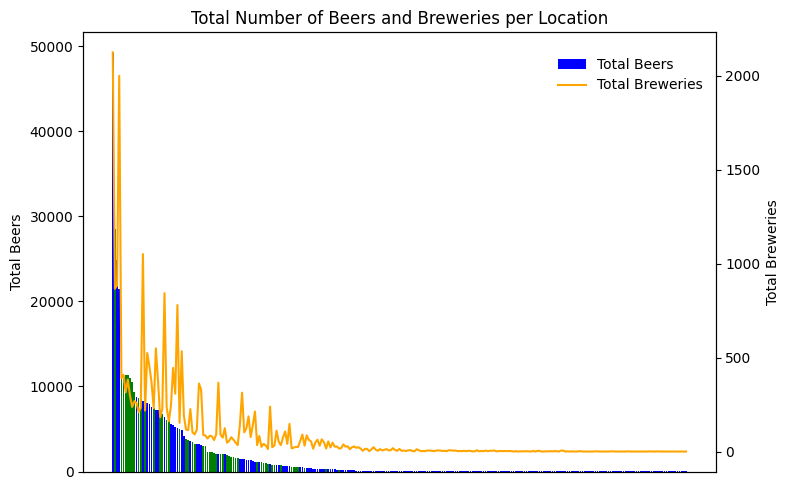

In [5]:
plot_beer_breweries_distribution(RB_breweries)

The top graphs is data from BeerAdvocate and the bottom from RateBeer. In the figures the green locations are US states and the blue represent all other countries, the orange line is breweries. Looking at BeerAdvocate, we can see that most of the locations selling high amounts of beers are based in the US. Brewery locations are offset for visibility. Since the majority of beers are being produced by the US, focusing only on the US won't be limiting the amount of data we have by that much. Additionally, looking at RateBeer, much less of the locations are US based, which justifies in part us not using RateBeer.

Number of users with known locations: 122425


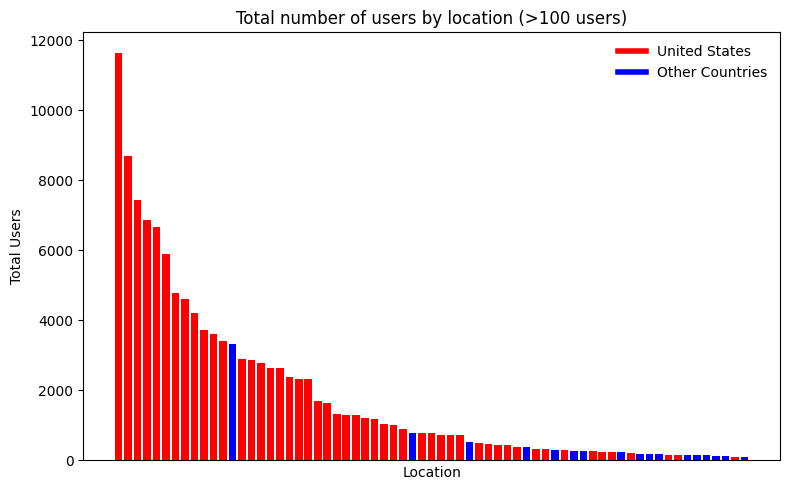

In [6]:
from src.choosingCountries.utils.users import plot_users

plot_users(BA_users)

Number of users with known locations: 50592


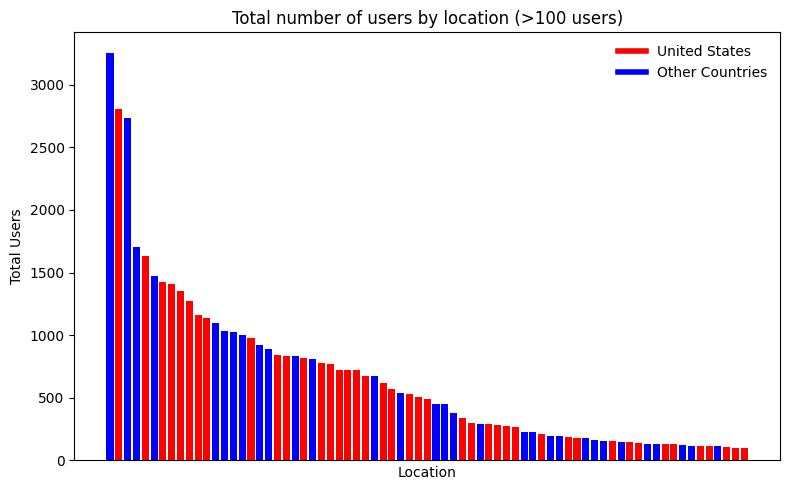

In [7]:
plot_users(RB_users)

The top plot is users from the BA dataset and the bottom from the RB dataset. The graphs show the distribution of users by location of origin (location must have more than 100 users). Again, in BA we see most of them are from the US, so focusing only on the US won't be limiting the amount of data we have too much, and again, RB shows many more non US users, further pointing us towards only using US BA data.

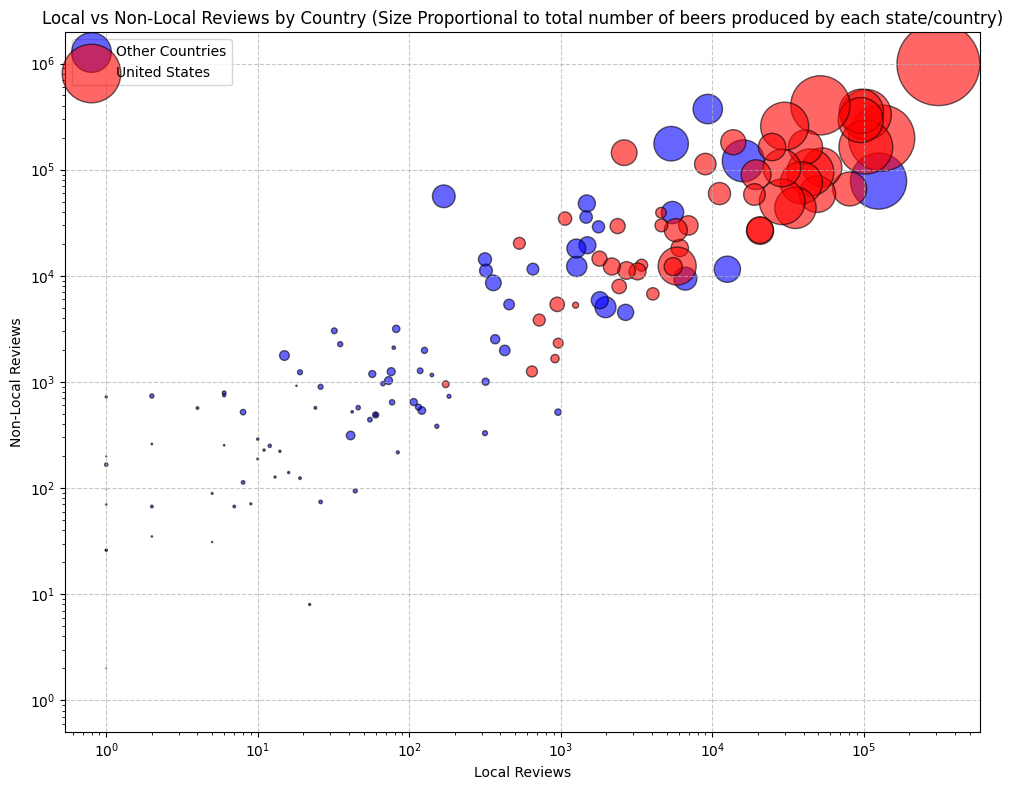

In [8]:
from src.choosingCountries.utils.reviews import plot_reviews

plot_reviews(BA_breweries, BA_merged)

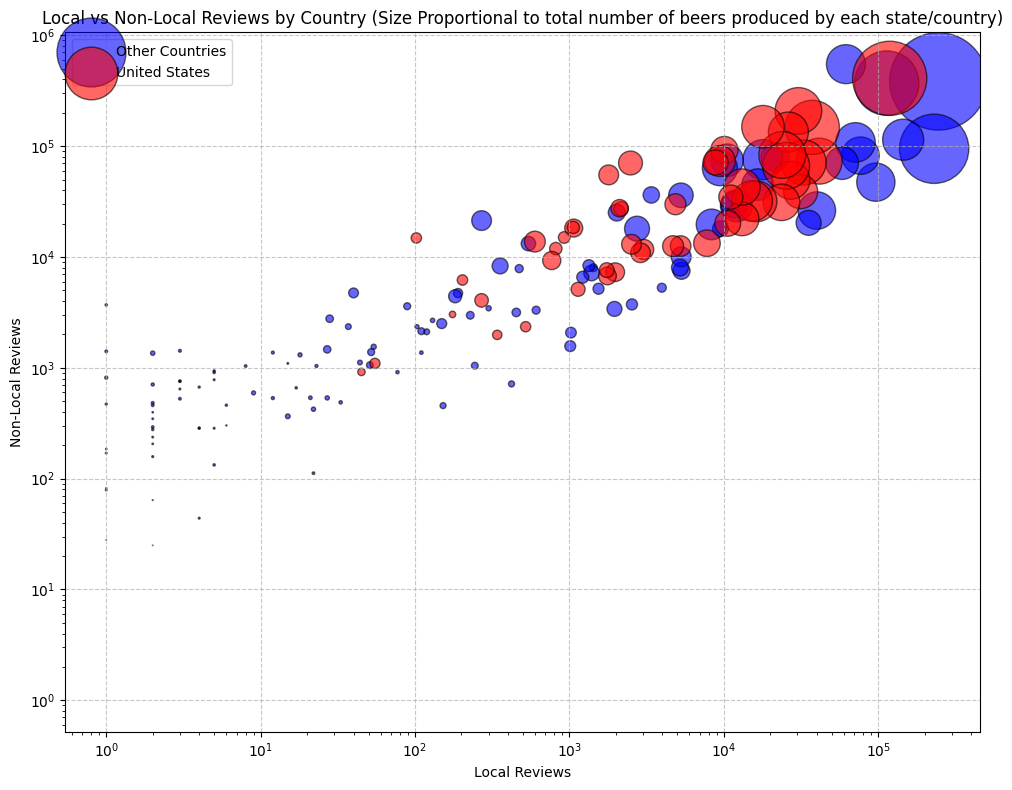

In [9]:
plot_reviews(RB_breweries, RB_merged)

The top plot is BA and the bottom RB. These graphs show the combined local/nonlocal reviews. Looking at the BA graph, the US dominates, with it being the most prevalent in the top right corner, on the contrary, looking at the RB graph, non US reviews are the majority in the top right corner.

In conclusion, we are choosing to restrict ourselves to the US so that we can make more meaningful interpretations, as there is already a lot of data, even for US only, and its easier to make more powerful conclusions on just the US rather than the whole world. Additionally, since BA contains a majority of US data, we feel that it's  more representative than RB, which has less US users. Thus we are choosing to focus solely on US based data from BA. We still have plenty of data points though (millions!), so we're not worried about not having enough data.

#### Q1) Regional analysis, do states in a region have similar taste in beer?

To visualise and understand the similarities between the beer ratings given by us states, we start by showing an interest in how neighbouring states rate their local beers. To do this, we grouped states by centering on each state and adding all its neighbouring states. This creates 50 separate regions, in which we calculate the similarities on those region’s beers (i.e. beers originating from the states in the corresponding group).

      region  rating user_state rating_type
0  Wisconsin    4.04  Wisconsin    In-State
1  Wisconsin    4.00  Wisconsin    In-State


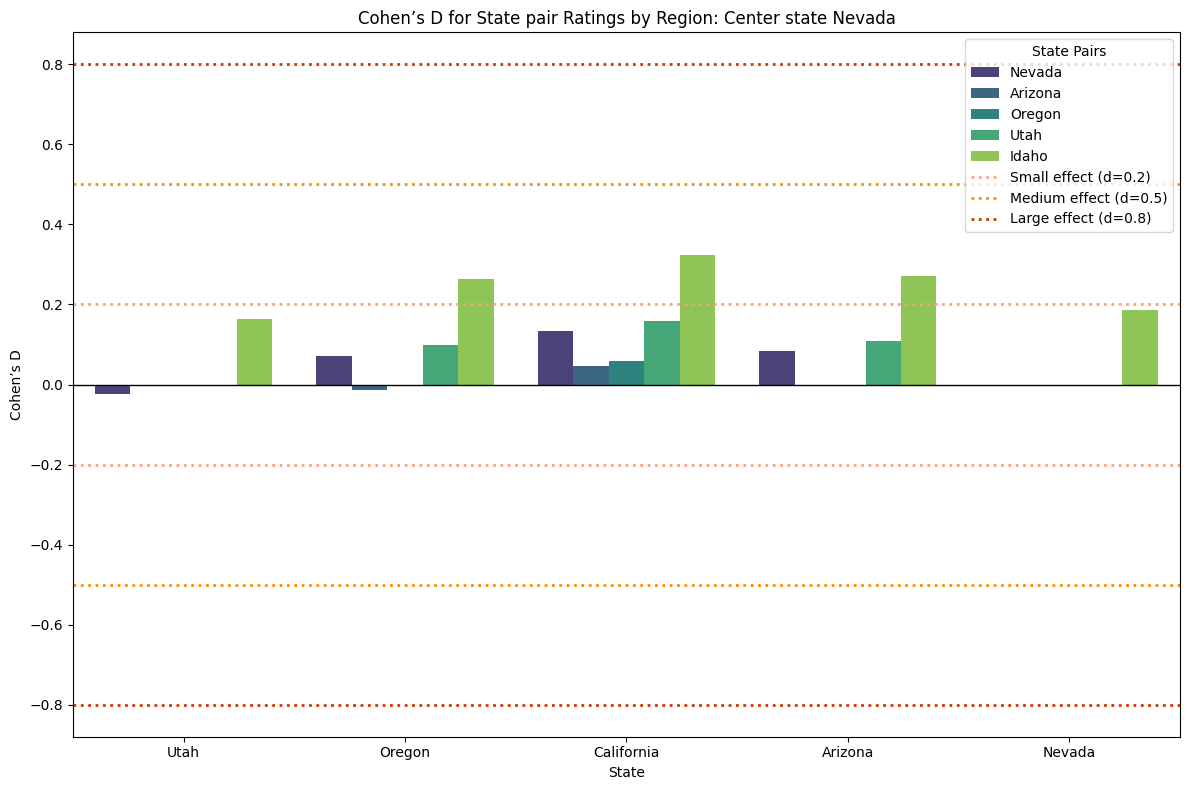

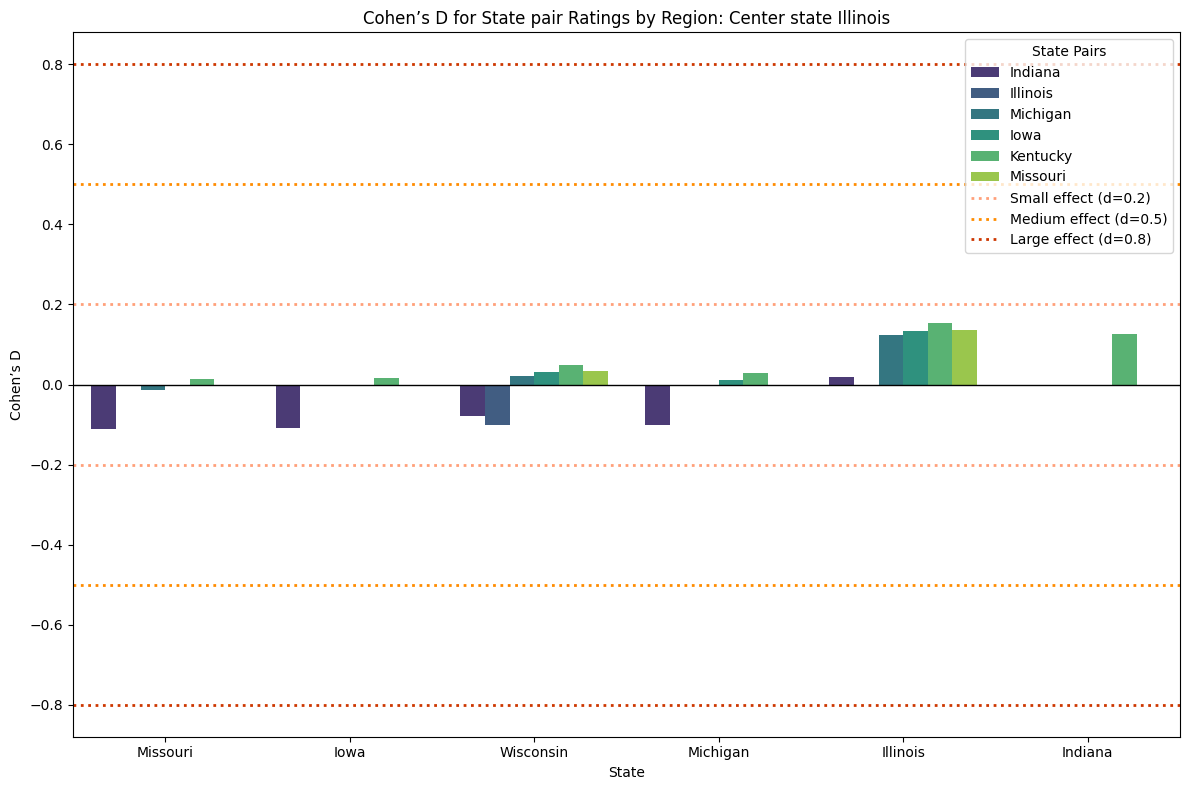

In [5]:
from src.questions.question1.utils.basicPlots import plot_cohenD_some_states
from src.questions.question1.utils.q1prepData import q1prep_data
#for some reason i need to reimport neighbours_df every time i want to use it, i do not know why. oh well...
neighbours_df = pd.read_csv('data/additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
ratings_df = q1prep_data(BA_US_ratings, neighbours_df)
df = plot_cohenD_some_states(ratings_df, plot = True)

To have an indication of the similarity, We calculate Cohen's D for each pair-wise interaction in the region, so we're looking at the distribution of beer ratings for beers coming from that region and rated by users from that region. 
From this we obtain a lot of graphs. These can vary from having low cohen’s d values, indicating that the states in the region have 'similar' or at the very least not significantly (in the Cohen's D sense) different distributions of ratings. And other regions show states with a significant variation (cohen’s d > 0.2), meaning they are different. 
<br>
Here are 2 examples, one region with significance, and one without.


In [11]:
from src.questions.question1.regionalAnalysis import regional_analysis
neighbours_df = pd.read_csv('data/additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
state_groups_df = regional_analysis(BA_US_ratings, neighbours_df)

      region  rating user_state rating_type
0  Wisconsin    4.04  Wisconsin    In-State
1  Wisconsin    4.00  Wisconsin    In-State


KeyboardInterrupt: 

Next, we can try to build a map based on these regions, to see if there's a geographical component. To do this, we regroup states based on ascending absolute cohen’s d value. In order to have an as accurate as possible regrouping of the states, we group together the two states with the lowest cohen’s d and from there on, if the next lowest cohen’s d value is has either state already in a group, it adds the second state to that group, and if neither is in a group, we place the state pair in a new group. <br>
In the case of both states already being in a group and these being 2 separate groups, we do not make any changes, ensuring that each state is placed with the state it is the most similar to. <br>
This allows for a grouping of states based on a local their ratings of local beers, however states such as Alaska and Hawaii will not display at all as they do not have any neighbours with which to calculate the cohen’s d in their region. <br>
The grouping and subsequent mapping of these, results in certain groups being spread across the continental USA, why some are more clustered around a geographical area. (group 7 and group 9 respectively). <br>
This first visualisation and grouping does show limitations as it only bases on a part of the information given by a user's review and gives us initial custom regions that can be compared to in future parts. <br>
This whole mapping is somewhat flawed as it groups only based on very local ratings for local products and does not take into consideration all the possible variations that we have in the beer ratings. The displayed Cohen's d values are therefore also not consistent as they depend on the center state and all its neighbours. This is however our first approach to seeing if there is an initial grouping of the states that can be done centered on each state. We then later on show an interest in more complex grouping based on more information.


But, this map was built on a state by state basis. If we instead group all states in a region together, and compare the distributions between regions, we can ask, are regions different from each other?

Q2) Do we see significant differences between regions when comparing beer ratings? 

After identifying trends within individual regions, we extended our analysis to compare beer ratings between regions. Our goal was to detect whether significant differences existed between how regions rated their own beers (in-region ratings) compared to beers from outside regions (out-region ratings). To quantify this, we used Cohen’s D, a statistical measure that assesses the standardized difference between two means. Cohen's D < 0.2 indicates a negligible difference.

In [ ]:
from src.questions.question2.utils.regions_cohenD import regions_cohenD
neighbours_df = pd.read_csv('data/additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
cohen_by_region_df = regions_cohenD(neighbours_df, BA_US_ratings)

To explore regional biases in beer ratings, we conducted a two-part analysis:
Neighboring bubbles analysis : We first examined whether users in each neighboring  bubble showed preferences for beers in their bubble compared to outside. However, all Cohen’s D were below 0.2, meaning there was no statistically significant difference between the ratings. This is surprising!

In [ ]:
**need toinseert the graph**

Instead of using our state and neighbours region to see differences, we can try to use the areas generated in question 1 and see if they are different. For these custom clusters, we compared in-region and out-region ratings using Cohen’s D. Again, all Cohen’s D values remained below 0.2, confirming that users did not rate beers from their own regions significantly higher.


So this motivates us to look at things on a state-by-state level, will there be differences there?

Q3) Looking at the state level, do we see more trends ? By doing a sentiment analysis do the text reviews reveal similar trends ? 

Since we don't see anything looking at it from a regional level, let us ask if at the state level, states have unique preferences that differ from all other states, not just states in their region.

In [ ]:
from src.choosingCountries.utils.heatmap import heatmap_avg_ratings
    
heatmap_avg_ratings(BA_US_ratings)

Here we see average ratings of beers coming from a specific state by users coming from a specific state. We were trying to see if any obvious patterns jumped out at us such as people from Alabama preferring beer from Alabama but it doesn't really seem so. All we can say is that beers coming from some states seem to be better rated than others, like Iowa, and beers coming from certain states are rated consistently lower, like Missouri. We replaced NaNs with 0's here, which is why we sometimes get these dark spots.

In [ ]:
from src.questions.question3.stateBias import state_bias

state_bias(BA_US_ratings)



Indeed we can see some differences between states! There are multiple states with significant cohen's D. This means that states do have preferences in their taste of beer.

In [ ]:
from src.questions.question3.utils.statesAvgD import plot_avg_and_D

plot_avg_and_D(BA_US_ratings)

In red we can see that most states do indeed have a bias in their beers compared to when rating out of state beers. For more than 50% of the states, this bias is positively weighted towards their own beers. However there are 17 states where there is actually a preference for out of state beers. By far, Missourians are guilty of rating their own beers more positively than beers from elsewhere in the US. 

##### Sentiment analysis

We know that there are states that have significant differences in the way they rate beers, when we look at the average rating. So, let's try and expand what we compare states on and look at textual data. For each person who left a text review of a specific beer, we can run this through a NLP pipeline (in our case we used an ultra stripped down pipe: just the en_core_web_sm and 'sentencizer' so that we could achieve fast performance, but it is still valid since we're only analyzing sentences, nothing else), and perform a sentiment analysis on this data. We can say that an individual sentence is ‘positive’, ‘negative’ or ‘neutral’, with a score for how positive/negative it is. Ideally, we would like to see that the sentiment bias revealed by the written text reviews align with the state specific biases uncovered using the ratings distributions.

In [ ]:
from src.questions.sentimentAnalysis.NLP_pipeline import NLP_results_analysis

NLP_results_analysis(BA_US_knn_text, path_BA='BA/')

Looking at the percentage of positive/negative/neutral sentences for each state, comparing local and non local reviews, the distributions between positive, neutral and negative reviews are pretty similar between all states. This is surprising, as we expected differences based on our earlier analysis of the ratings. So we tried some statistical tests to see if there are significant differences.<br>
We performed a chi2 test followed by a cramer’s V test (equivalent to cohen’s D but for categorical values), but as we can see, although the p-values are small for the chi2-test (likely due to large population size), the cramer’s V tells us that the effect size is negligible, thus there is no significant difference between the populations of locals and non locals!<br>
Next we tried using cohen’s D but on the score of the sentences (value between -1 and 0 for negative sentences and 0 and 1 for positive sentences), but unfortunately we also find that the effect size is quite small, thus there are again no significant differences between local and nonlocal reviews for a state.<br>
In conclusion, much to our surprise, contrary to analysis just based on average ratings, where we did find results, it seems that just analyzing the text reviews reveals no bias when it comes to local and nonlocal beers. A possible explanation for this is that people who leave text reviews are more likely to have a positive experience, so we’re sampling reviews that are mostly positive (indeed they are looking at the stacked barchart), giving us no meaningful difference for locals and on locals, as people who've had an average or negative experience won’t bother leaving a text review.


So far in our analyses we’ve focused on the ratings that users give, but there are other factors at play.

#### Q4) Looking deeper into preferences, does separating by beer style reveal a style specific bias that could explain these differences in ratings?

From preliminary analysis simply using the ratings for each beer style, we were able to calculate the preference of beer by style for each state. This was calculated by taking an average rating weighted by the number of reviews for a given style. The American IPA consistently placed first as the top beer for all states. Second and third were the Imperial IPA and Imperial Stout. However when looking at the number of reviews by style for each state we can see that there three are the most consistently reviewed beers by Americans and is therefore perhaps masking any state level trends we would otherwise see. By only looking at the average rating, we are unable to see any state specific preference when it comes to style preference. Therefore we thought it interesting to include other parameters.

c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\styleAnalysis\utils\logWeights.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_style_stats_thresh['weight'] = state_style_stats_thresh['average_rating'] * np.log1p(state_style_stats_thresh['nb_ratings'])
c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\styleAnalysis\utils\logWeights.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_style_stats_thresh['normalized_weight'] = state_style_stats_thresh['weight'] / state_style_

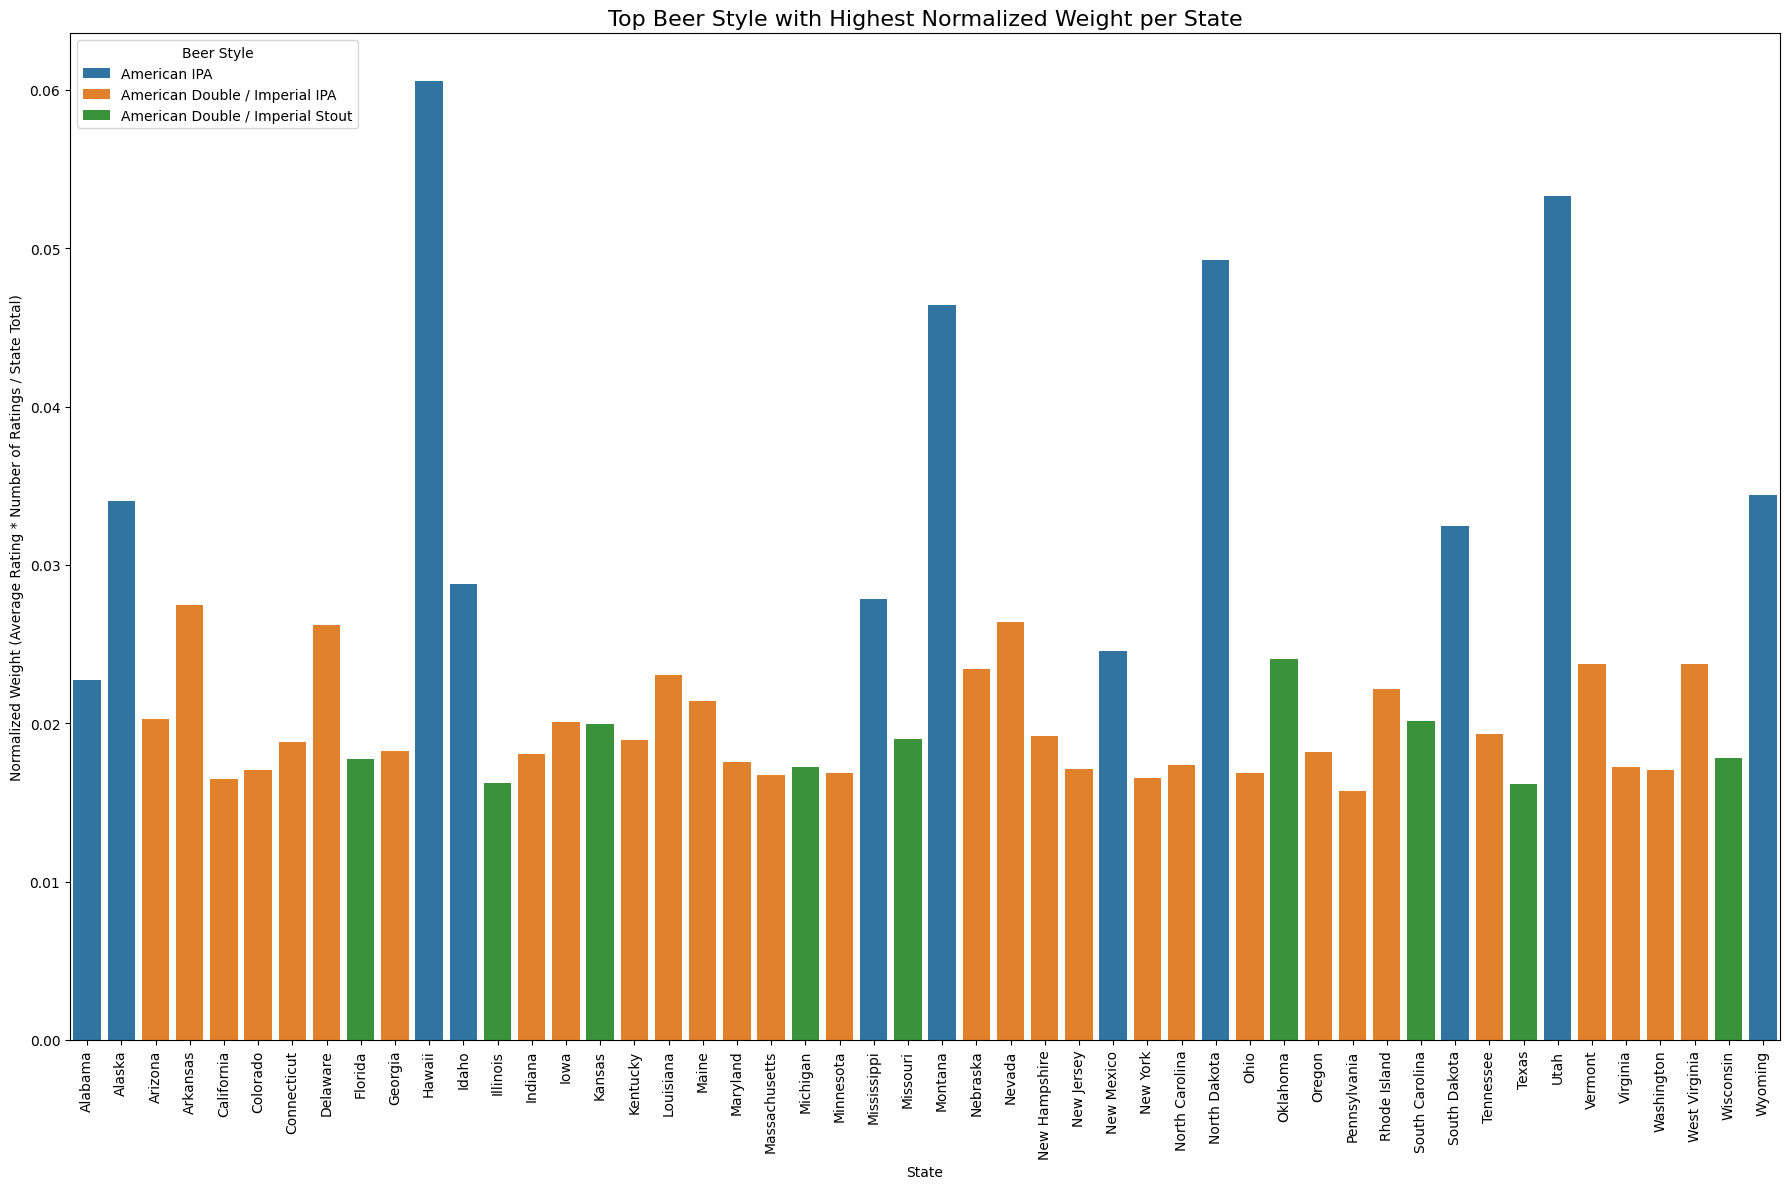

In [12]:
from src.questions.styleAnalysis.utils.logWeights import log_top_styles

state_style_stats = BA_US_ratings.groupby(['user_state', 'style']).agg(average_rating=('rating', 'mean'),nb_ratings=('rating', 'size')).reset_index() #calculating the number of ratings and average ratings per state per beer style

top_style_per_state = log_top_styles(state_style_stats)

Thanks for reading!